# 205: Project 3, Jonathan Hernandez

In [1]:
import neo4j
import pandas as pd
from IPython.display import display

In [2]:
import matplotlib.pyplot as plt
from neo4j import GraphDatabase # required for graph algorithms
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

## Remember the Basics

- Calmly, Orderly, Systematically, Logically... reduce the Search Space
- Expect and make peace with frustration and confusion. Both demonstrate stretching ourselves out of our comfort zone, learning at our maximum potential, not limiting ourselves to what is easy to learn. 

#### Nodes (vertices) can have: labels for classification and properties (attributes as key / value pairs)

#### Relationships (edges) can have: type, direction, and properties (attributes as key / value pairs); 

Additional Reading: 
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html

#### Jupyter Hotkeys for VSC

Creating Cells

1. Create a Code Cell After the Current Position:
• Mac: Option + Enter
	This hotkey will create a new code cell directly below the currently selected cell and move the cursor to the new cell.

2. Create a Markdown Cell After the Current Position:
• Mac: Cmd + Shift + Option + M
	Alternatively, you can convert an existing code cell to a markdown cell using:
	•Mac: M (when the cell is in command mode)

Running Cells

1. Run All Cells Above a Certain Point:
	There isn’t a direct hotkey to run all cells above the current point. However, you can accomplish this by:
	• Command Palette: Cmd + Shift + P (Mac) to open the Command Palette, then type “Run Above” and select “Run Above”.

#### Web server interface at https://xxxx:7473

**Username: neo4j**

**Password: ucb_mids_w205**

The above web server allows and interactive GUI which can output graphs visually in addition to table like output.  The nodes in the graphs can be moved around with the mouse to make the graphs more readable.


#### Basics:

```:server connect``` - connect to the server, username is "neo4j", password is "ucb_mids_w205"

```:server status``` - shows that username and server you are logged into

```:clear``` - clears off old cells

```show databases``` - note that community edition only has 1 application database that we can use neo4j, we cannot create now use other databases, we have to wipe out neo4j database for each new graph

#### Cypher as the query language: 
- analogous to SQL for a relational database; Cypher is open source and like SQL is used for multiple database, Cypher can be used for other graph databases


```()``` node


```[]``` relationships


```-> <-``` directions, every relationship must have 1 and only 1 direction


```(p:Person)``` p is a variable, Person is a node label


```(:Person)``` no variable, Person is a node label


```(p:Person {name: 'John', birth_year: 1970})``` name is a property of the node with value 'John', and birth_year is a property with value 1970


```(p1:Person {name: 'John'})-[r:IS_FRIEND_OF]->(p2:Person {name: 'Mary'})``` r is a variable, IS_FRIEND_OF is a relationship type


```(p1:Person {name: 'John'})-[:IS_FRIEND_OF {since: 1983}]->(p2:Person {name: 'Mary'})``` since is a property of the relationship

```match``` matches a pattern of nodes and/or relationships

```return``` which properties of nodes and/or relationships to return

```order by``` sorting just like SQL

```limit```  limiting the rows returned just like SQL

```collect``` a form of a pivot to turn rows into a list

```unwind``` a form of an unpivot to turn a list into rows

```create``` creates nodes and/or relationships

```delete``` deletes nodes and/or relationships

### Connect, login, create driver, create session; with community edition, we can only use 1 database, the "neo4j" database

In [3]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://<EXTERNAL_IP>:7687", auth=("neo4j", "ucb_mids_w205"))


In [4]:
# driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

Local -> Cloud access, comment out prior to submitting

In [60]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

In [61]:
session = driver.session(database="neo4j")

# Function Definitions

### Visualize Graph (This is not required for the cells with the core graph creation functions to run*****)

In [49]:
# PRODUCTION VERSION

# !pip install networkx
# !pip install py2neo
# !pip install scipy
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

# Function to visualize the graph using networkx
def visualize_graph(title="Neo4j Graph Visualization"):
    # Connect to the Neo4j database
    graph = Graph("bolt://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))

    # Define a query to get nodes and relationships
    query = """
    MATCH (n)-[r]->(m)
    RETURN n.name AS from, type(r) AS type, m.name AS to
    """

    # Run the query
    results = graph.run(query)

    # Create a NetworkX graph
    G = nx.DiGraph()

    # Add nodes and edges to the NetworkX graph
    for record in results:
        G.add_edge(record["from"], record["to"], label=record["type"])

    # Choose a layout algorithm
    # pos = nx.spring_layout(G, k=0.5)  # k controls the distance between nodes - CHAOS
    # pos = nx.circular_layout(G) #  DIFFICULT TO WEIGHT
    # pos = nx.shell_layout(G) # BETTER
    pos = nx.kamada_kawai_layout(G, weight=None) # 

    # Draw the nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->', arrowsize=45)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="normal")

    # Draw the edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Display the graph
    plt.title(title)
    plt.show()

### my_neo4j_wipe_out_database() 
- since community edition can only have 1 database "neo4j", this function will wipe out all the nodes and relationships

In [8]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

### my_neo4j_run_query_pandas() 
will run a Cypher query and put the results in a Pandas dataframe; easy to see how you can use Python to manipulate the returned data

In [9]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

### my_neo4j_nodes_relationships() 
- will print the nodes (assumes a name property) and relationships

In [10]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Project Three Coding Submission, By Jonathan Hernandez

This project was inspired by Unit 12 of DATASCI 207, Applied Machine Learning, and the paper, 'A Framework for Understanding Sources of Harm throughout the Machine Learning Life Cycle' by Suresh and Guttag, 2021. 

These graphs look at two things: 
- 1. The Machine Learning Workflow, its Nodes, Processes, and Biases
- 2. A Fictitious Future Structure of a company known as OpenAI. This structure takes place in 2034, after launching a fictiious subsidiary called OpenAI Web Services (OWS), loosely inspired by my experience working at AWS.

There are four graphs, relating two Sets of Nodes, gradually increasing complexity, and three submission-worthy graph algorithms, one extra is included at the end. 

The algorithms are only run on the final version of the graph, and the first three versions are merely illustrative.   

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/paper/source/source_graph.png)

## Graph 1: Set A: Machine Learning Workflow with Bias Nodes

In [41]:
my_neo4j_wipe_out_database()

query = """
CREATE
  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0),

// link population definition and sampling, measurement, preprocessing tran/test split, and benchmarks
  (a01)-[:FEEDS]->(a10),
  (a10)-[:FEEDS]->(a20),
  (a20)-[:FEEDS]->(a5)

"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Data Generation,[PROCESS]
3,Dataset,[ML_Workflow]
4,Deployment Bias,[BIAS]
5,Evaluation,[PROCESS]
6,Evaluation Bias,[BIAS]
7,Historical Bias,[BIAS]
8,Human & Model Interaction,[PROCESS]
9,Integrate into Systems,[PROCESS]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Data Generation,[PROCESS],FEEDS,World,[ML_Workflow]
4,Dataset,[ML_Workflow],FEEDS,"Preprocessing, Train/Test Split",[PROCESS]
5,Deployment Bias,[BIAS],BIASES,Human & Model Interaction,[PROCESS]
6,Deployment Bias,[BIAS],BIASES,Integrate into Systems,[PROCESS]
7,Deployment Bias,[BIAS],BIASES,Model Output,[ML_Workflow]
8,Deployment Bias,[BIAS],BIASES,Post-Process,[PROCESS]
9,Deployment Bias,[BIAS],BIASES,Run Model,[PROCESS]


-------------------------
  Density: 0.2
-------------------------


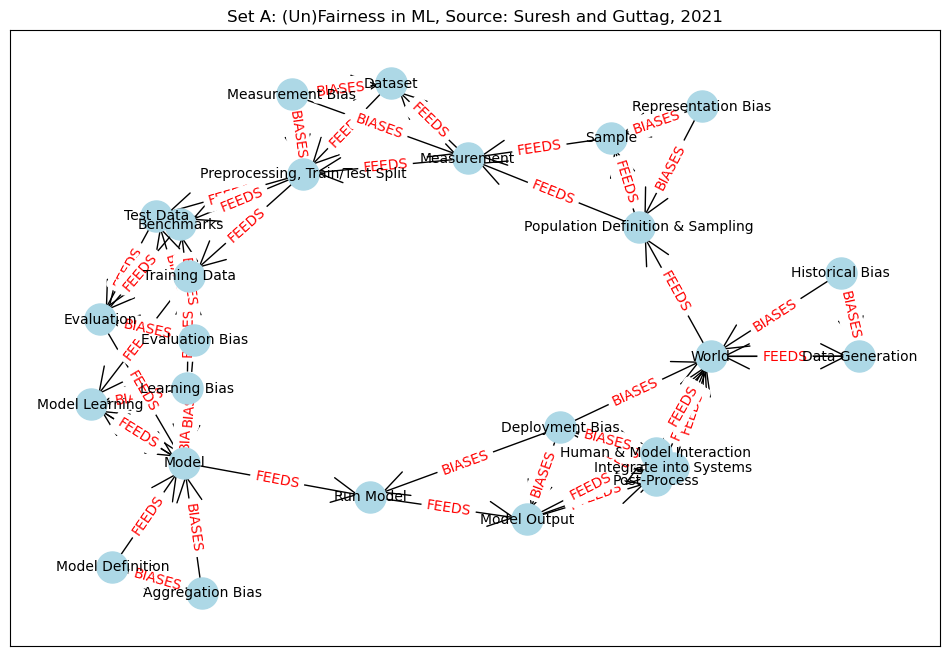

In [43]:
my_neo4j_nodes_relationships()
visualize_graph('Set A: (Un)Fairness in ML, Source: Suresh and Guttag, 2021')

![Set A: Unfairness in ML Graph](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Set_A.png)

## Graph 2: Set C: Company Set of Nodes

Define the nodes, then define the relationships

In [26]:
my_neo4j_wipe_out_database()

query = """
CREATE
  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  (c0)-[:IS_PARENT_OF {since: 1984}]->(c00),
  (c00)-[:IS_PARENT_OF]->(c1),
  (c1)-[:IS_PARENT_OF]->(c2),
  (c1)-[:IS_PARENT_OF]->(c3),
  (c1)-[:IS_PARENT_OF]->(c4),
  (c1)-[:IS_PARENT_OF]->(c5),
  (c1)-[:IS_PARENT_OF]->(c6),
  (c1)-[:IS_PARENT_OF]->(c7),
  (c1)-[:IS_PARENT_OF]->(c8),
  (c1)-[:IS_PARENT_OF]->(c9),
  (c1)-[:IS_PARENT_OF]->(c10),
  (c1)-[:IS_PARENT_OF]->(c11),
  (c1)-[:IS_PARENT_OF]->(c12),
  (c1)-[:IS_PARENT_OF]->(c13),
  (c1)-[:IS_PARENT_OF]->(c14),
  (c1)-[:IS_PARENT_OF]->(c15),
  (c1)-[:IS_PARENT_OF]->(c16),
  (c1)-[:IS_PARENT_OF]->(c17),
  (c1)-[:IS_PARENT_OF]->(c18),
  (c1)-[:IS_PARENT_OF]->(c19),
  (c1)-[:IS_PARENT_OF]->(c20),
  (c1)-[:IS_PARENT_OF]->(c21)

"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Biotechnology,[Company]
1,Business Services,[Company]
2,Consumer Goods and Services,[Company]
3,Education,[Company]
4,Energy,[Company]
5,Financial Markets,[Company]
6,Financial Services,[Company]
7,Government,[Company]
8,Healthcare,[Company]
9,Information Technology,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,"OpenAI Global, LLC.",[Company],IS_PARENT_OF,OpenAI Web Services,[Company]
1,OpenAI Web Services,[Company],IS_PARENT_OF,Biotechnology,[Company]
2,OpenAI Web Services,[Company],IS_PARENT_OF,Business Services,[Company]
3,OpenAI Web Services,[Company],IS_PARENT_OF,Consumer Goods and Services,[Company]
4,OpenAI Web Services,[Company],IS_PARENT_OF,Education,[Company]
5,OpenAI Web Services,[Company],IS_PARENT_OF,Energy,[Company]
6,OpenAI Web Services,[Company],IS_PARENT_OF,Financial Markets,[Company]
7,OpenAI Web Services,[Company],IS_PARENT_OF,Financial Services,[Company]
8,OpenAI Web Services,[Company],IS_PARENT_OF,Government,[Company]
9,OpenAI Web Services,[Company],IS_PARENT_OF,Healthcare,[Company]


-------------------------
  Density: 0.1
-------------------------


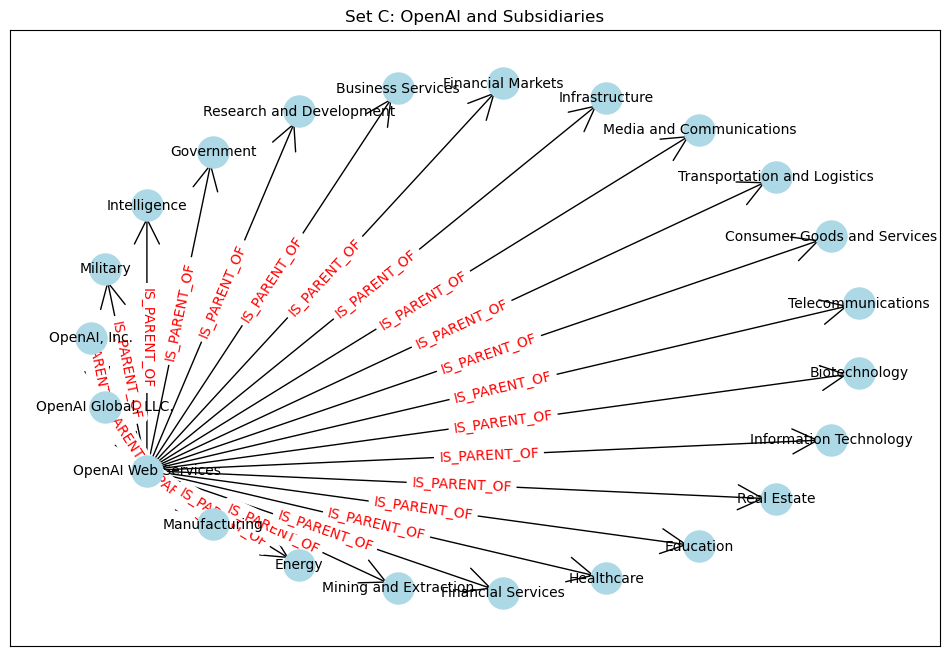

In [27]:
my_neo4j_nodes_relationships()
visualize_graph('Set C: OpenAI and Subsidiaries')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Set_C.png)

## Graph 3: Set A & C: Ownership / Relational Model

Notation Guide: 
- 1 digit:  ML_Workflow or Company Node
- 2 digits: PROCESS
- 3 digits: bias

In [29]:
my_neo4j_wipe_out_database()

query = """
CREATE

  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.
  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (c0)-[:IS_PARENT_OF {since: 1984}]->(c00),
  (c00)-[:IS_PARENT_OF]->(c1),
  (c1)-[:IS_PARENT_OF]->(c2),
  (c1)-[:IS_PARENT_OF]->(c3),
  (c1)-[:IS_PARENT_OF]->(c4),
  (c1)-[:IS_PARENT_OF]->(c5),
  (c1)-[:IS_PARENT_OF]->(c6),
  (c1)-[:IS_PARENT_OF]->(c7),
  (c1)-[:IS_PARENT_OF]->(c8),
  (c1)-[:IS_PARENT_OF]->(c9),
  (c1)-[:IS_PARENT_OF]->(c10),
  (c1)-[:IS_PARENT_OF]->(c11),
  (c1)-[:IS_PARENT_OF]->(c12),
  (c1)-[:IS_PARENT_OF]->(c13),
  (c1)-[:IS_PARENT_OF]->(c14),
  (c1)-[:IS_PARENT_OF]->(c15),
  (c1)-[:IS_PARENT_OF]->(c16),
  (c1)-[:IS_PARENT_OF]->(c17),
  (c1)-[:IS_PARENT_OF]->(c18),
  (c1)-[:IS_PARENT_OF]->(c19),
  (c1)-[:IS_PARENT_OF]->(c20),
  (c1)-[:IS_PARENT_OF]->(c21),

  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0),

  // link population definition and sampling, measurement, preprocessing tran/test split, and benchmarks
  (a01)-[:FEEDS]->(a10),
  (a10)-[:FEEDS]->(a20),
  (a20)-[:FEEDS]->(a5),

// Linking Sets A and C  
  (a7)-[:FEEDS]->(c00), // Model feeds OpenAI Global
  (c00)-[:IS_PARENT_OF]->(a7) // OpenAI Global owns the Model

"""

session.run(query)


-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Biotechnology,[Company]
3,Business Services,[Company]
4,Consumer Goods and Services,[Company]
5,Data Generation,[PROCESS]
6,Dataset,[ML_Workflow]
7,Deployment Bias,[BIAS]
8,Education,[Company]
9,Energy,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Data Generation,[PROCESS],FEEDS,World,[ML_Workflow]
4,Dataset,[ML_Workflow],FEEDS,"Preprocessing, Train/Test Split",[PROCESS]
...,...,...,...,...,...
68,Sample,[ML_Workflow],FEEDS,Measurement,[PROCESS]
69,Test Data,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
70,Training Data,[ML_Workflow],FEEDS,Model Learning,[PROCESS]
71,World,[ML_Workflow],FEEDS,Data Generation,[PROCESS]


-------------------------
  Density: 0.1
-------------------------


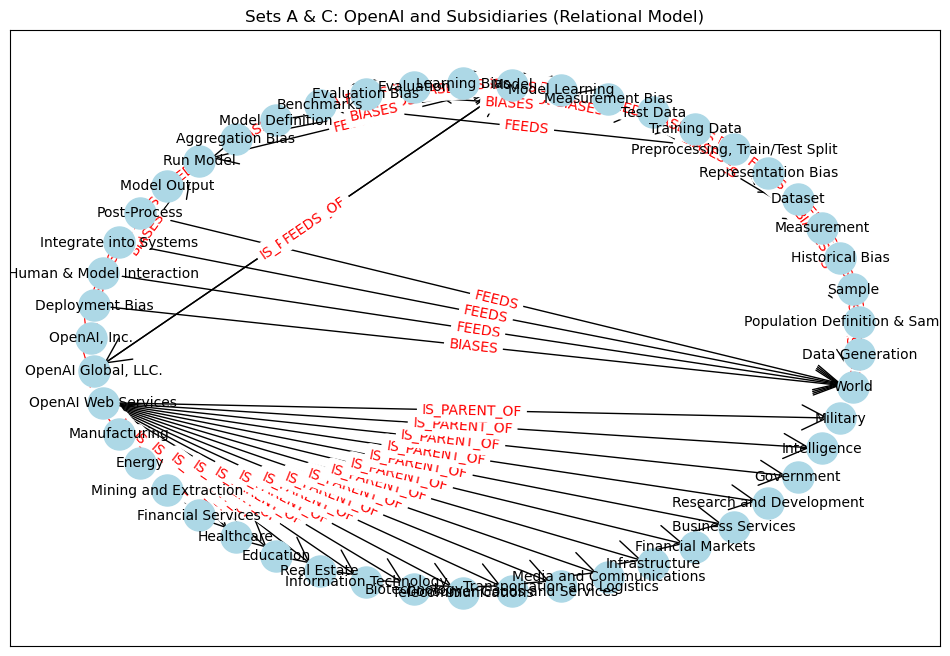

In [38]:
my_neo4j_nodes_relationships()
visualize_graph('Sets A & C: OpenAI and Subsidiaries (Relational Model)')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Sets_A_C_Relational_Model.png)

## Graph 4: Set A & C:Operational Realistic Model

Notation Guide: 
- 1 digit:  ML_Workflow or Company Node
- 2 digits: PROCESS
- 3 digits: bias


In [63]:
my_neo4j_wipe_out_database()

query = """
CREATE

  // Source: Fictitious
  (c0:Company {name: 'OpenAI, Inc.'}),
  (c00:Company {name: 'OpenAI Global, LLC.'}),
  (c1:Company {name: 'OpenAI Web Services'}),
  (c2:Company {name: 'Manufacturing'}),
  (c3:Company {name: 'Energy'}),
  (c4:Company {name: 'Mining and Extraction'}),
  (c5:Company {name: 'Financial Services'}),
  (c6:Company {name: 'Healthcare'}),
  (c7:Company {name: 'Education'}),
  (c8:Company {name: 'Real Estate'}),
  (c9:Company {name: 'Information Technology'}),
  (c10:Company {name: 'Biotechnology'}),
  (c11:Company {name: 'Telecommunications'}),
  (c12:Company {name: 'Consumer Goods and Services'}),
  (c13:Company {name: 'Transportation and Logistics'}),
  (c14:Company {name: 'Media and Communications'}),
  (c15:Company {name: 'Infrastructure'}),
  (c16:Company {name: 'Financial Markets'}),
  (c17:Company {name: 'Business Services'}),
  (c18:Company {name: 'Research and Development'}),
  (c19:Company {name: 'Government'}),
  (c20:Company {name: 'Intelligence'}),
  (c21:Company {name: 'Military'}),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.

  (a0:ML_Workflow {name: 'World', bias: 'Historical Bias'}), //
  (a00:PROCESS {name: 'Data Generation'}),
  (a01:PROCESS {name: 'Population Definition & Sampling'}),
  (a000:BIAS {name: 'Historical Bias'}),
  (a1:ML_Workflow {name: 'Sample'}), //
  (a10:PROCESS {name: 'Measurement'}),
  (a100:BIAS {name: 'Representation Bias'}),
  (a2:ML_Workflow {name: 'Dataset'}), //
  (a20:PROCESS {name: 'Preprocessing, Train/Test Split'}),
  (a200:BIAS {name: 'Measurement Bias'}),
  (a3:ML_Workflow {name: 'Training Data'}), //
  (a30:PROCESS {name: 'Model Learning'}),
  (a300:BIAS {name: 'Learning Bias'}),
  (a4:ML_Workflow {name: 'Test Data'}), //
  (a40:PROCESS {name: 'Evaluation'}),
  (a400:BIAS {name: 'Evaluation Bias'}),
  (a5:ML_Workflow {name: 'Benchmarks'}), // feeds evaluation
  (a60:PROCESS {name: 'Model Definition'}), //  feeds model
  (a600:BIAS {name: 'Aggregation Bias'}), 
  (a7:ML_Workflow {name: 'Model'}), // feeds model output
  (a70:PROCESS {name: 'Run Model'}),
  (a8:ML_Workflow {name: 'Model Output'}), // 
  (a80:PROCESS {name: 'Post-Process'}),
  (a81:PROCESS {name: 'Integrate into Systems'}),
  (a82:PROCESS {name: 'Human & Model Interaction'}),
  (a800:BIAS {name: 'Deployment Bias'}),

  (c0)-[:FEEDS {since: 1984}]->(c00),
  (c00)-[:FEEDS]->(c1),
  (c1)-[:FEEDS]->(c2),
  (c1)-[:FEEDS]->(c3),
  (c1)-[:FEEDS]->(c4),
  (c1)-[:FEEDS]->(c5),
  (c1)-[:FEEDS]->(c6),
  (c1)-[:FEEDS]->(c7),
  (c1)-[:FEEDS]->(c8),
  (c1)-[:FEEDS]->(c9),
  (c1)-[:FEEDS]->(c10),
  (c1)-[:FEEDS]->(c11),
  (c1)-[:FEEDS]->(c12),
  (c1)-[:FEEDS]->(c13),
  (c1)-[:FEEDS]->(c14),
  (c1)-[:FEEDS]->(c15),
  (c1)-[:FEEDS]->(c16),
  (c1)-[:FEEDS]->(c17),
  (c1)-[:FEEDS]->(c18),
  (c1)-[:FEEDS]->(c19),
  (c1)-[:FEEDS]->(c20),
  (c1)-[:FEEDS]->(c21),

  // Source: Suresh and Guttag. A Framework for Understanding Sources of Harm throughout the Machine Learning Lifecycle. 2021.
  (a0)-[:FEEDS]->(a00), //
  (a0)-[:FEEDS]->(a01), //
  (a00)-[:FEEDS]->(a0),
  (a01)-[:FEEDS]->(a1),
  (a000)-[:BIASES]->(a0),
  (a000)-[:BIASES]->(a00),
  (a1)-[:FEEDS]->(a10), //
  (a10)-[:FEEDS]->(a2),
  (a100)-[:BIASES]->(a01),
  (a100)-[:BIASES]->(a1),
  (a2)-[:FEEDS]->(a20), //
  (a20)-[:FEEDS]->(a3),
  (a20)-[:FEEDS]->(a4),
  (a200)-[:BIASES]->(a10),
  (a200)-[:BIASES]->(a2),
  (a200)-[:BIASES]->(a20),
  (a30)-[:FEEDS]->(a7), //
  (a7)-[:FEEDS]->(a30),
  (a3)-[:FEEDS]->(a30),
  (a300)-[:BIASES]->(a3),
  (a300)-[:BIASES]->(a30),
  (a300)-[:BIASES]->(a7),
  (a4)-[:FEEDS]->(a40), //
  (a40)-[:FEEDS]->(a7),
  (a400)-[:BIASES]->(a4),
  (a400)-[:BIASES]->(a40),
  (a400)-[:BIASES]->(a5),
  (a400)-[:BIASES]->(a7),
  (a5)-[:FEEDS]->(a40), //
  (a60)-[:FEEDS]->(a7), //
  (a600)-[:BIASES]->(a60),
  (a600)-[:BIASES]->(a7),
  (a7)-[:FEEDS]->(a70), //
  (a70)-[:FEEDS]->(a8),
  (a8)-[:FEEDS]->(a80), //
  (a8)-[:FEEDS]->(a81),
  (a8)-[:FEEDS]->(a82),
  (a80)-[:FEEDS]->(a0),
  (a81)-[:FEEDS]->(a0),
  (a82)-[:FEEDS]->(a0),
  (a800)-[:BIASES]->(a8),
  (a800)-[:BIASES]->(a70),
  (a800)-[:BIASES]->(a80),
  (a800)-[:BIASES]->(a81),
  (a800)-[:BIASES]->(a82),
  (a800)-[:BIASES]->(a0),

  //
  (c00)-[:FEEDS]->(a70), 
  // New relationships between c1-c21 and a0: World
  (c1)-[:FEEDS]->(a0),
  (c2)-[:FEEDS]->(a0),
  (c3)-[:FEEDS]->(a0),
  (c4)-[:FEEDS]->(a0),
  (c5)-[:FEEDS]->(a0),
  (c6)-[:FEEDS]->(a0),
  (c7)-[:FEEDS]->(a0),
  (c8)-[:FEEDS]->(a0),
  (c9)-[:FEEDS]->(a0),
  (c10)-[:FEEDS]->(a0),
  (c11)-[:FEEDS]->(a0),
  (c12)-[:FEEDS]->(a0),
  (c13)-[:FEEDS]->(a0),
  (c14)-[:FEEDS]->(a0),
  (c15)-[:FEEDS]->(a0),
  (c16)-[:FEEDS]->(a0),
  (c17)-[:FEEDS]->(a0),
  (c18)-[:FEEDS]->(a0),
  (c19)-[:FEEDS]->(a0),
  (c20)-[:FEEDS]->(a0),
  (c21)-[:FEEDS]->(a0),

  // link population definition and sampling, measurement, preprocessing tran/test split, and benchmarks
  (a01)-[:FEEDS]->(a10),
  (a10)-[:FEEDS]->(a20),
  (a20)-[:FEEDS]->(a5), //done with Set A enhancements

  // Linking Sets A and C  
  (a7)-[:FEEDS]->(c00), // Model feeds OpenAI Global
  (c00)-[:FEEDS]->(a8), // OpenAI Global runs the model 

  //one last thing
  (a800)-[:BIASES]->(c00) // Deployment Bias affects OpenAI Global

"""

session.run(query)

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,Aggregation Bias,[BIAS]
1,Benchmarks,[ML_Workflow]
2,Biotechnology,[Company]
3,Business Services,[Company]
4,Consumer Goods and Services,[Company]
5,Data Generation,[PROCESS]
6,Dataset,[ML_Workflow]
7,Deployment Bias,[BIAS]
8,Education,[Company]
9,Energy,[Company]


-------------------------
  Relationships:
-------------------------


,node_name_1,node_1_labels,relationship_type,node_name_2,node_2_labels
0,Aggregation Bias,[BIAS],BIASES,Model,[ML_Workflow]
1,Aggregation Bias,[BIAS],BIASES,Model Definition,[PROCESS]
2,Benchmarks,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
3,Biotechnology,[Company],FEEDS,World,[ML_Workflow]
4,Business Services,[Company],FEEDS,World,[ML_Workflow]
...,...,...,...,...,...
91,Test Data,[ML_Workflow],FEEDS,Evaluation,[PROCESS]
92,Training Data,[ML_Workflow],FEEDS,Model Learning,[PROCESS]
93,Transportation and Logistics,[Company],FEEDS,World,[ML_Workflow]
94,World,[ML_Workflow],FEEDS,Data Generation,[PROCESS]


-------------------------
  Density: 0.1
-------------------------


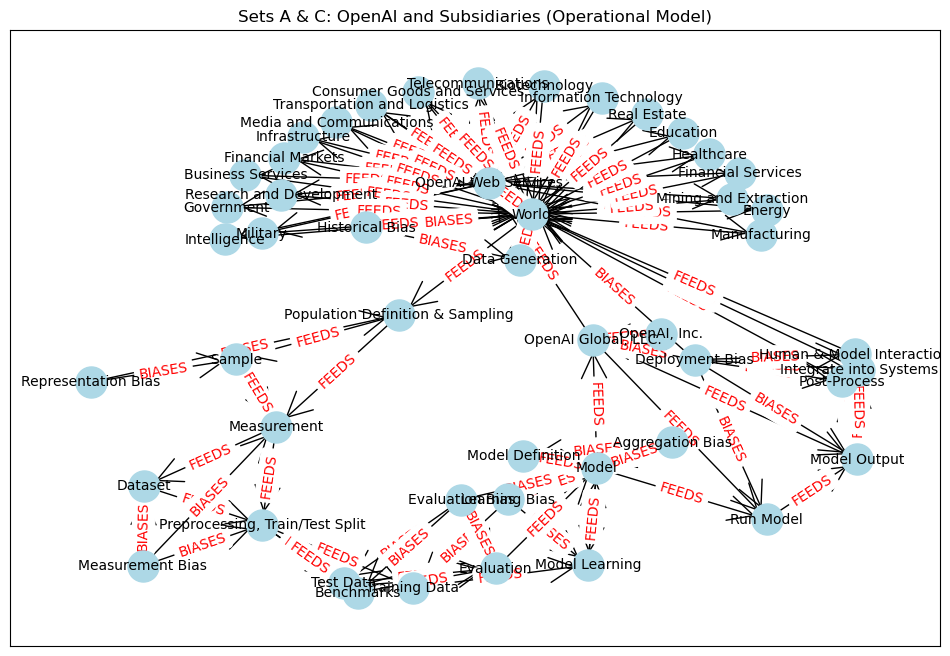

In [64]:
my_neo4j_nodes_relationships()
visualize_graph('Sets A & C: OpenAI and Subsidiaries (Operational Model)')

![Alt text](/Users/home/VSCode/mids/project-3-JH-UCB/code/images/Sets_A_C_Operational_Model.png)

## Algorithm 1: Degree Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Degree Centrality Results
--------------------------------
                                Node  Degree Centrality
0                OpenAI Web Services               21.0
1                    Deployment Bias                7.0
2                    Evaluation Bias                4.0
3                OpenAI Global, LLC.                3.0
4    Preprocessing, Train/Test Split                3.0
5                   Measurement Bias                3.0
6                      Learning Bias                3.0
7                              Model                3.0
8                       Model Output                3.0
9                              World                2.0
10  Population Definition & Sampling                2.0
11                   Historical Bias                2.0
12                       Measurement                2.0
13               Representation Bias                2.0
14                  Aggregation Bias                2.0
15      

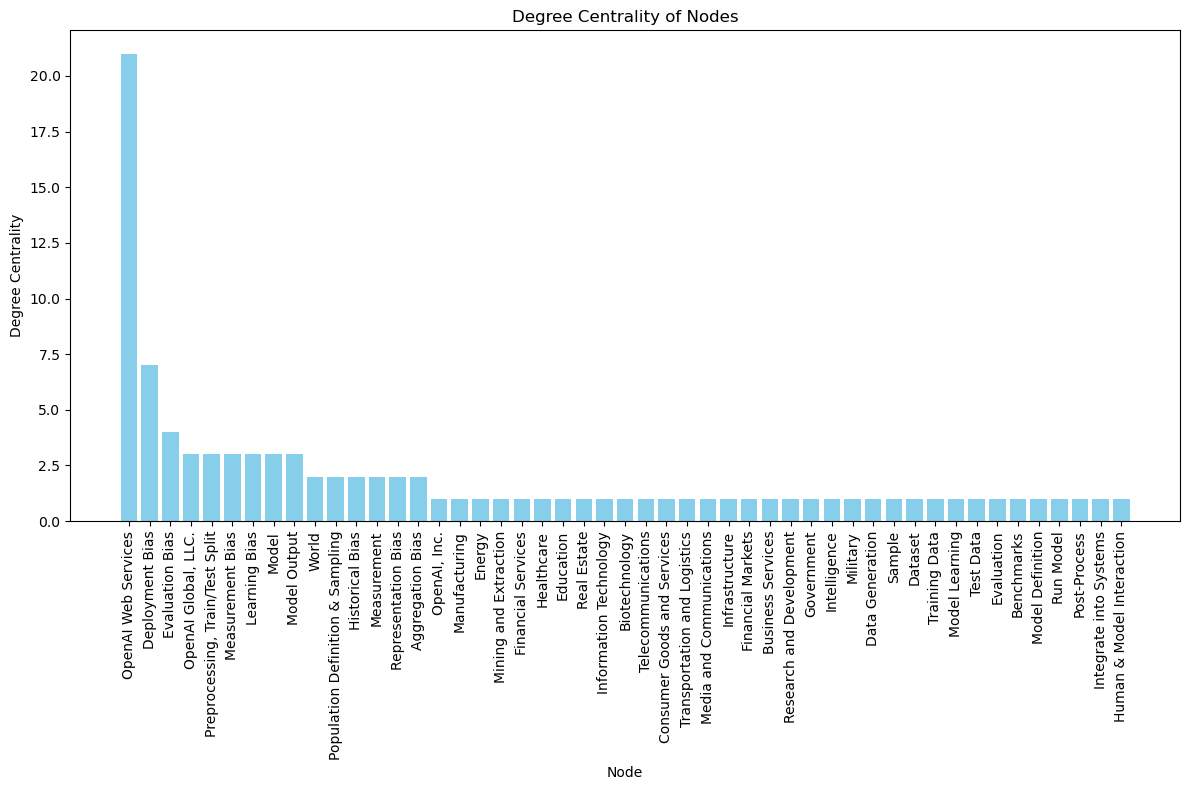

In [53]:
def my_neo4j_degree_centrality():
    """
    Compute the degree centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")

    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the degree centrality algorithm
    query = """
    CALL gds.degree.stream('ds_graph')
    YIELD nodeId, score AS centrality
    RETURN gds.util.asNode(nodeId).name AS node, centrality
    ORDER BY centrality DESC
    """

    result = session.run(query)

    data = []
    for r in result:
        data.append({"Node": r['node'], "Degree Centrality": r['centrality']})
    df = pd.DataFrame(data)
    
    print("\n--------------------------------")
    print("   Degree Centrality Results")
    print("--------------------------------")
    print(df)
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Degree Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Degree Centrality')
    plt.title('Degree Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_degree_centrality()

Degree Centrality measures the number of direct connections a graph node has and is a proxy for how important or influential a node might be in the network. 

- OpenAI Web Services (OWS) has the highest number of direct connections, by far
- Deployment and Evaluation Biases are next
- The non-profit parent company, Open AI, Inc., who is technically the owner and operator of OpenAI Global, LLC, has a less central role in how influential it is throughout the graph. 

## Algorithm 2: Betweenness Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Betweenness Centrality Results
--------------------------------
                                Node  Betweenness Centrality
0                              World              568.000000
1   Population Definition & Sampling              490.000000
2                             Sample              474.000000
3                        Measurement              443.000000
4                            Dataset              412.000000
5    Preprocessing, Train/Test Split              395.000000
6                              Model              327.000000
7                          Run Model              299.000000
8                       Model Output              268.000000
9                          Test Data              161.500000
10                     Training Data              155.500000
11                        Evaluation              147.500000
12                    Model Learning              131.500000
13               OpenAI Web Services         

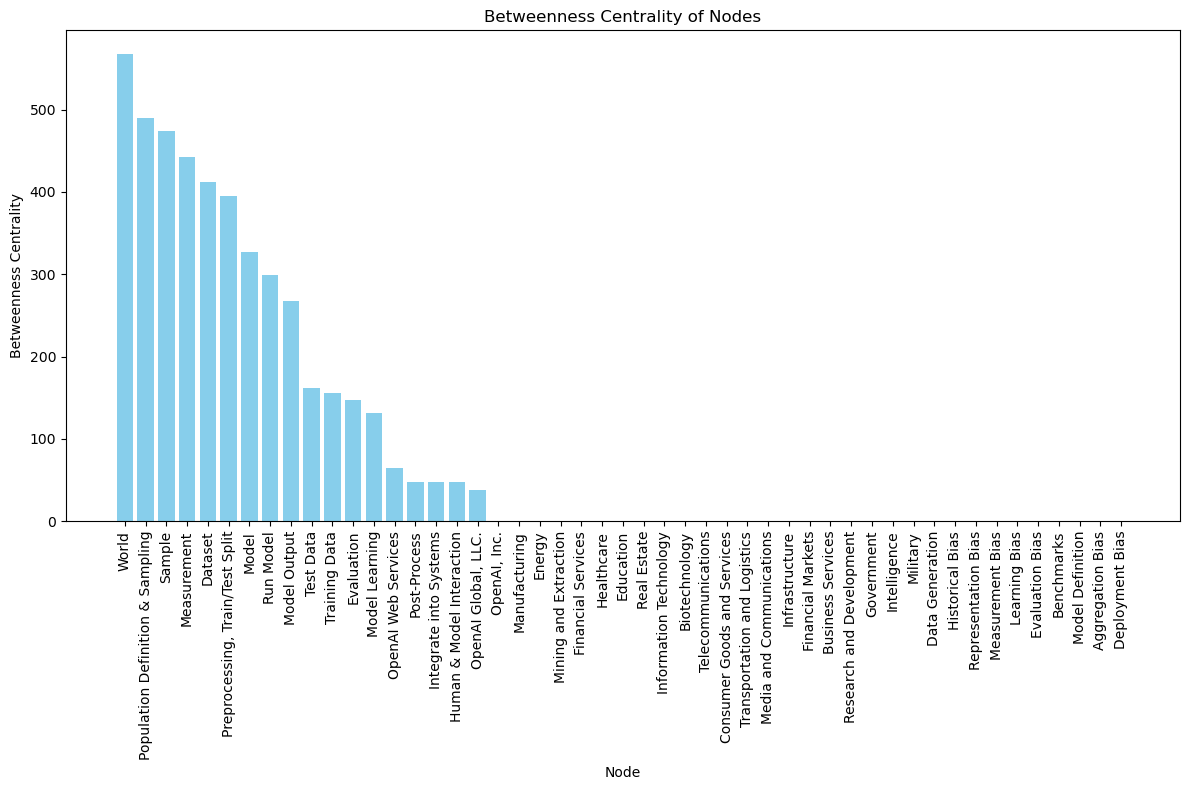

In [20]:
def my_neo4j_betweenness_centrality():
    """
    Compute the betweenness centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the betweenness centrality algorithm
    query = """
    CALL gds.betweenness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS node, score AS betweenness
    ORDER BY betweenness DESC
    """

    result = session.run(query)
    
    # Store the results in a df
    data = []
    for r in result:
        data.append({"Node": r['node'], "Betweenness Centrality": r['betweenness']})
    
    df = pd.DataFrame(data)
    
    print("\n--------------------------------")
    print("   Betweenness Centrality Results")
    print("--------------------------------")
    print(df)
    
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Betweenness Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Betweenness Centrality')
    plt.title('Betweenness Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_betweenness_centrality()

Betweenness Centrality measures the number of times a node acts as a bridge along the shortest path between two other nodes. It serves as a proxy for how important a node is in controlling the flow of information or energy within the graph network

- The World, Population & Sampling, Measuring and making Datasets are all the most important aspects of bridging the shortest paths between other nodes. The results indicate that in a high flow rate environment, globally, operational changes within these aspects of the graph could have outsized positive (or negative) influence, accumulating changes across each traversal.

## Algorithm 3: Label Propagation

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph_feeds', false)"



--------------------------------
 Label Propagation Results (FEEDS)
--------------------------------
                                Node  Community
0                OpenAI Global, LLC.         51
1                OpenAI Web Services         51
2                      Manufacturing         51
3                             Energy         51
4              Mining and Extraction         51
5                 Financial Services         51
6                         Healthcare         51
7                          Education         51
8                        Real Estate         51
9             Information Technology         51
10                     Biotechnology         51
11                Telecommunications         51
12       Consumer Goods and Services         51
13      Transportation and Logistics         51
14          Media and Communications         51
15                    Infrastructure         51
16                 Financial Markets         51
17                 Business Servic

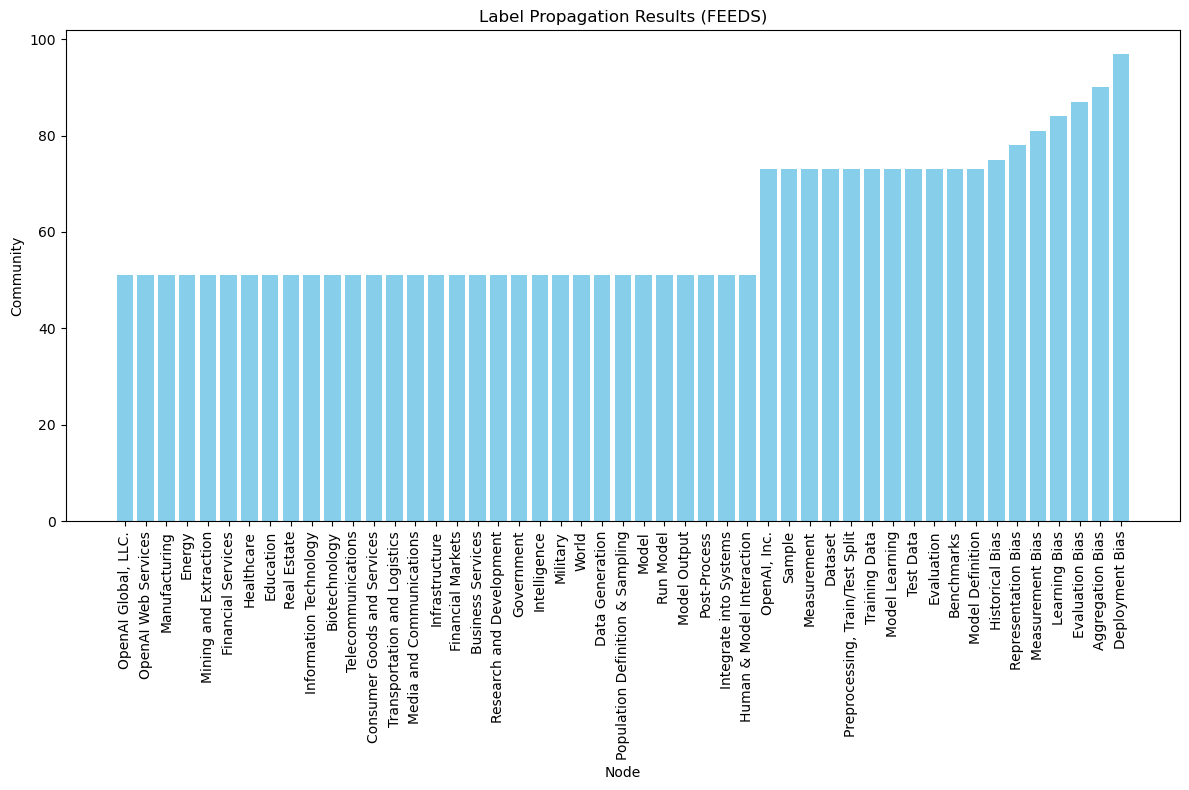

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph_biases', false)"



--------------------------------
 Label Propagation Results (BIASES)
--------------------------------
                                Node  Community
0                       OpenAI, Inc.         49
1                OpenAI Global, LLC.         50
2                    Deployment Bias         50
3                OpenAI Web Services         51
4                      Manufacturing         52
5                             Energy         53
6              Mining and Extraction         54
7                 Financial Services         55
8                         Healthcare         56
9                          Education         57
10                       Real Estate         58
11            Information Technology         59
12                     Biotechnology         60
13                Telecommunications         61
14       Consumer Goods and Services         62
15      Transportation and Logistics         63
16          Media and Communications         64
17                    Infrastruct

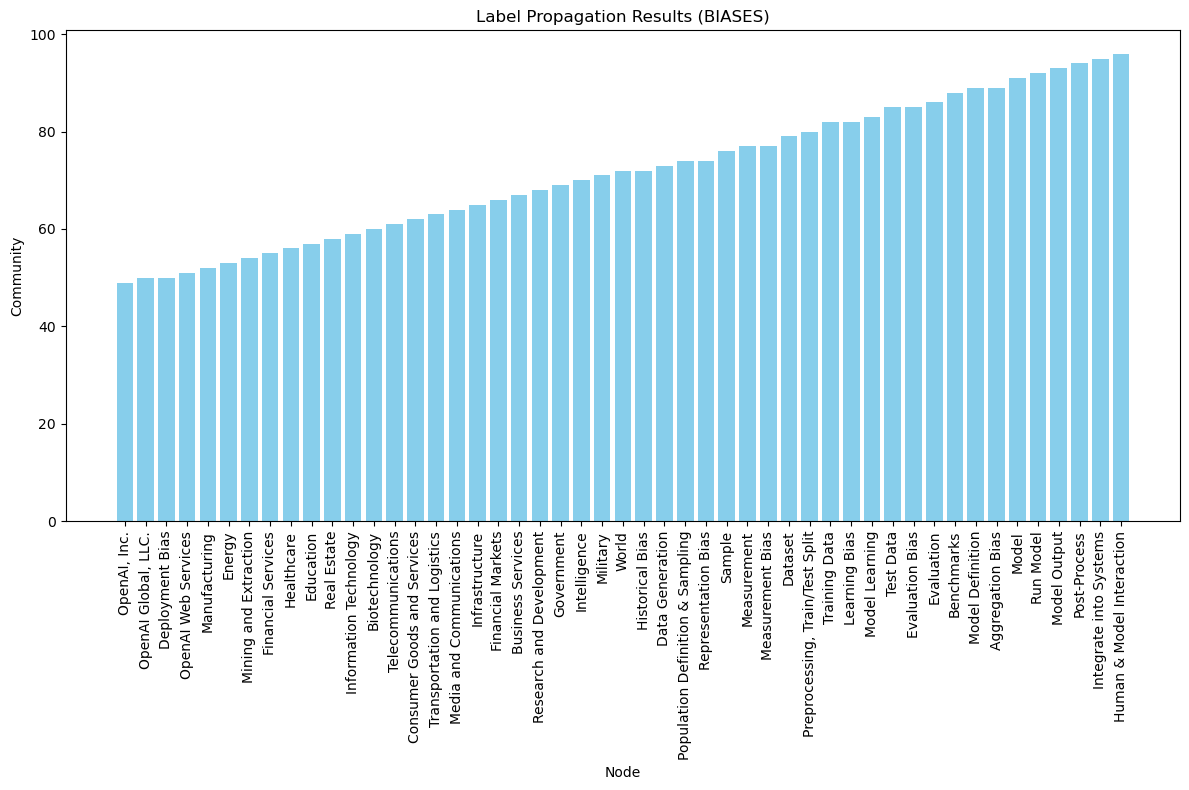

In [91]:
def my_neo4j_lpa_pull(max_iterations=10):
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")

    relationships = ['FEEDS', 'BIASES']
    for i, relationship in enumerate(relationships):
        graph_name = f'ds_graph_{relationship.lower()}'

        query = f"CALL gds.graph.drop('{graph_name}', false)"
        session.run(query)

        # Preprocess relationships to add weight property based on their count
        if relationship == 'FEEDS':
            preprocess_query = """
            MATCH (a)-[r:FEEDS]->(b)
            WITH a, b, COUNT(r) AS weight
            MERGE (a)-[newR:FEEDS {weight: weight}]->(b)
            """
        elif relationship == 'BIASES':
            preprocess_query = """
            MATCH (a)-[r:BIASES]->(b)
            WITH a, b, COUNT(r) AS weight
            MERGE (a)-[newR:BIASES {weight: weight}]->(b)
            """
        session.run(preprocess_query)

        query = f"""
        CALL gds.graph.project(
            '{graph_name}',
            ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'],
            {{
                {relationship}: {{
                    orientation: 'NATURAL',
                    properties: {{
                        weight: {{
                            defaultValue: 1.0
                        }}
                    }}
                }}
            }}
        )
        """
        session.run(query)

        query = f"""
        CALL gds.labelPropagation.stream('{graph_name}', {{
            maxIterations: {max_iterations},
            relationshipWeightProperty: 'weight'
        }})
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).name AS node, communityId
        ORDER BY communityId
        """
        result = session.run(query)

        data = []
        for r in result:
            data.append({"Node": r['node'], "Community": r['communityId']})
        df = pd.DataFrame(data)
        print(f"\n--------------------------------")
        print(f" Label Propagation Results ({relationship})")
        print("--------------------------------")
        print(df)

        # Plot the results
        plt.figure(figsize=(12, 8))
        plt.bar(df['Node'], df['Community'], color='skyblue')
        plt.xlabel('Node')
        plt.ylabel('Community')
        plt.title(f'Label Propagation Results ({relationship})')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

my_neo4j_lpa_pull(max_iterations=10)

## Ungraded Additional Algorithms for Exploration

### Algorithm 4: Louvain Modularity

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"



--------------------------------
   Louvain Modularity Results
--------------------------------
                                Node  Community ID
0                       OpenAI, Inc.            31
1                              Model            31
2                OpenAI Global, LLC.            43
3                OpenAI Web Services            43
4                      Manufacturing            43
5                             Energy            43
6              Mining and Extraction            43
7                 Financial Services            43
8                         Healthcare            43
9                          Education            43
10                       Real Estate            43
11            Information Technology            43
12                     Biotechnology            43
13                Telecommunications            43
14       Consumer Goods and Services            43
15      Transportation and Logistics            43
16          Media and Communications

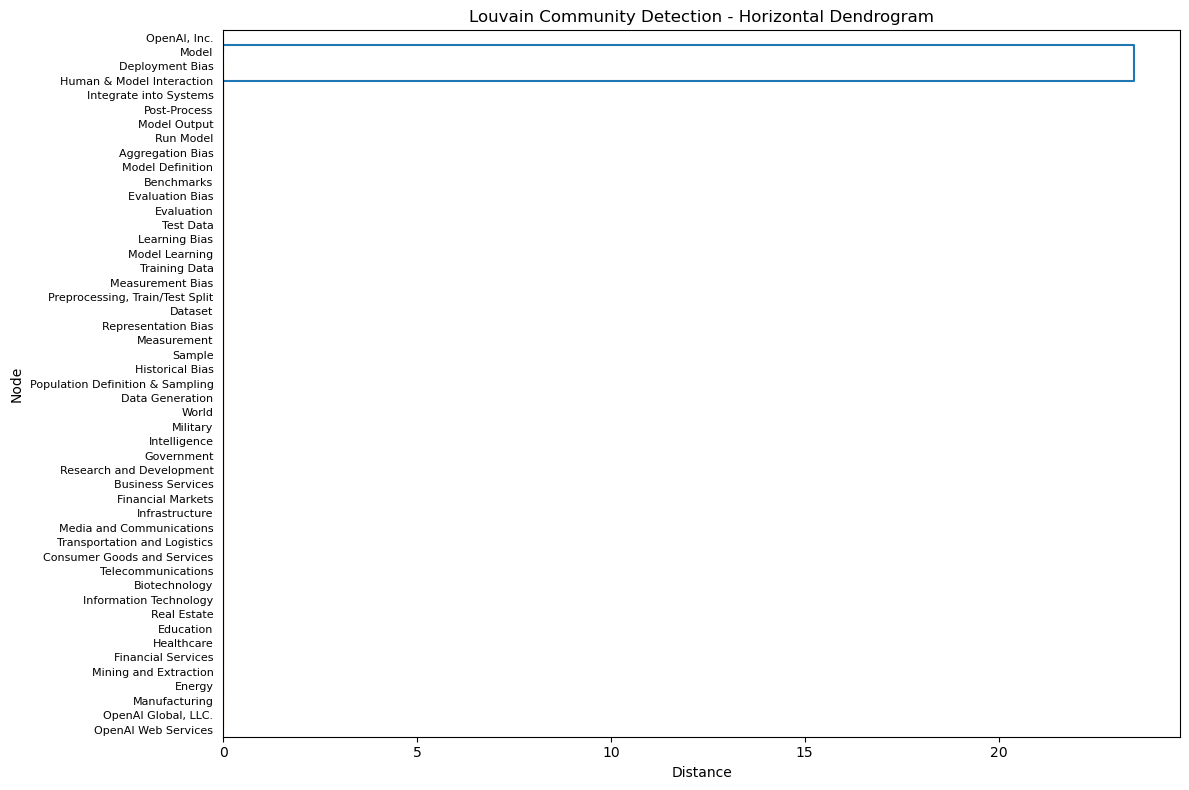

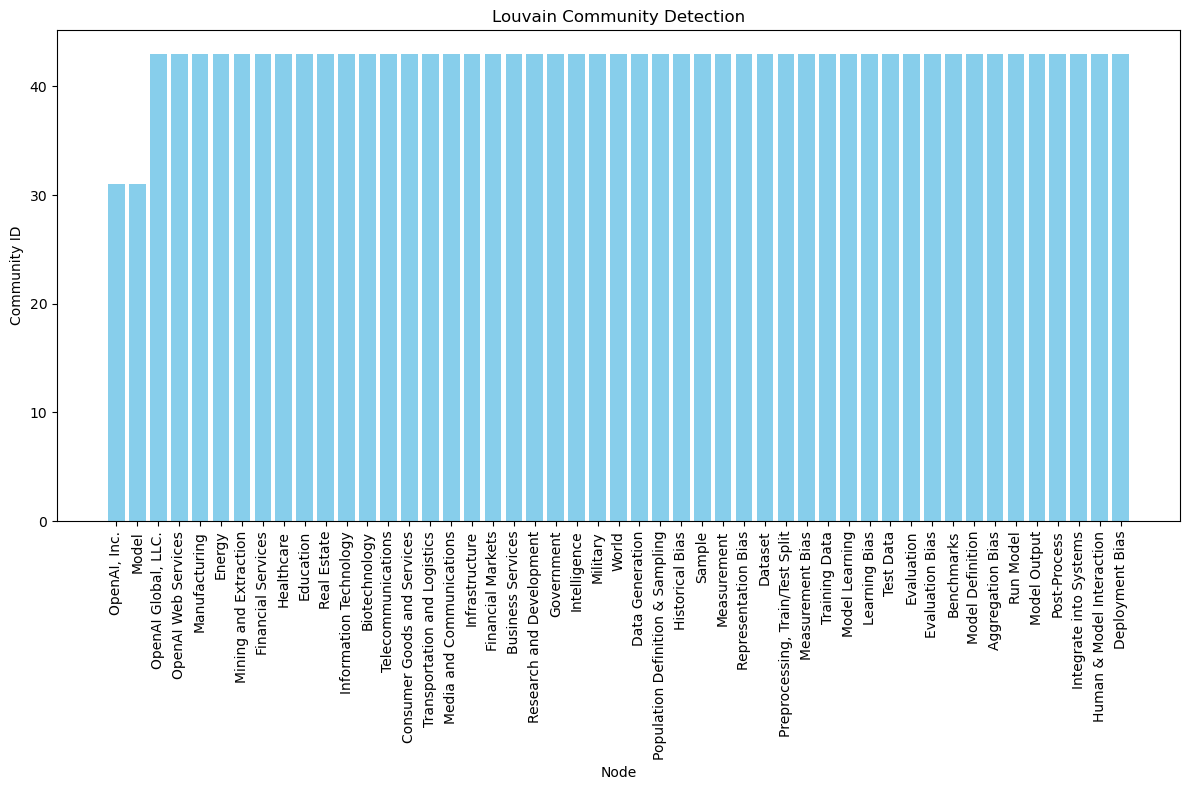

In [94]:
def my_neo4j_louvain_modularity():
    """
    Compute the Louvain modularity for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the Louvain modularity algorithm
    query = """
    CALL gds.louvain.stream('ds_graph')
    YIELD nodeId, communityId
    RETURN gds.util.asNode(nodeId).name AS node, communityId
    ORDER BY communityId
    """

    result = session.run(query)
    
    # Store the results in a DataFrame
    data = []
    for r in result:
        data.append({"Node": r['node'], "Community ID": r['communityId']})
    
    df = pd.DataFrame(data)
    
    # Print the results
    print("\n--------------------------------")
    print("   Louvain Modularity Results")
    print("--------------------------------")
    print(df)


    # horizontal dendrogram
    plt.figure(figsize=(12, 8))
    linked = linkage(df['Community ID'].values.reshape(-1, 1), method='ward')
    dendrogram(linked, labels=df['Node'].values, orientation='right', distance_sort='descending', show_leaf_counts=True)

    plt.xlabel('Distance')
    plt.ylabel('Node')
    plt.title('Louvain Community Detection - Horizontal Dendrogram')
    plt.tight_layout()
    plt.show()

    # bar plot
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Community ID'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Community ID')
    plt.title('Louvain Community Detection')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_louvain_modularity()

### Algorithm 5: Harmonic Centrality

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL gds.graph.drop('ds_graph', false)"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated procedure. ('gds.alpha.closeness.harmonic.stream' has been replaced by 'gds.closeness.harmonic.stream')} {position: line: 2, column: 1, offset: 5} for query: "\n    CALL gds.alpha.closeness.harmonic.stream('ds_graph')\n    YIELD nodeId, centrality\n    RETURN gds.util.asNode(nodeId).name


--------------------------------
   Harmonic Centrality Results
--------------------------------
                                Node  Harmonic Centrality
0                              World             0.667841
1   Population Definition & Sampling             0.400951
2                    Data Generation             0.384516
3                        Measurement             0.328431
4                             Sample             0.301811
5                              Model             0.284292
6    Preprocessing, Train/Test Split             0.282267
7                     Model Learning             0.272966
8                            Dataset             0.263748
9                          Run Model             0.256878
10               OpenAI Global, LLC.             0.248545
11                     Training Data             0.243246
12                         Test Data             0.243246
13                        Benchmarks             0.243246
14                        Evalua

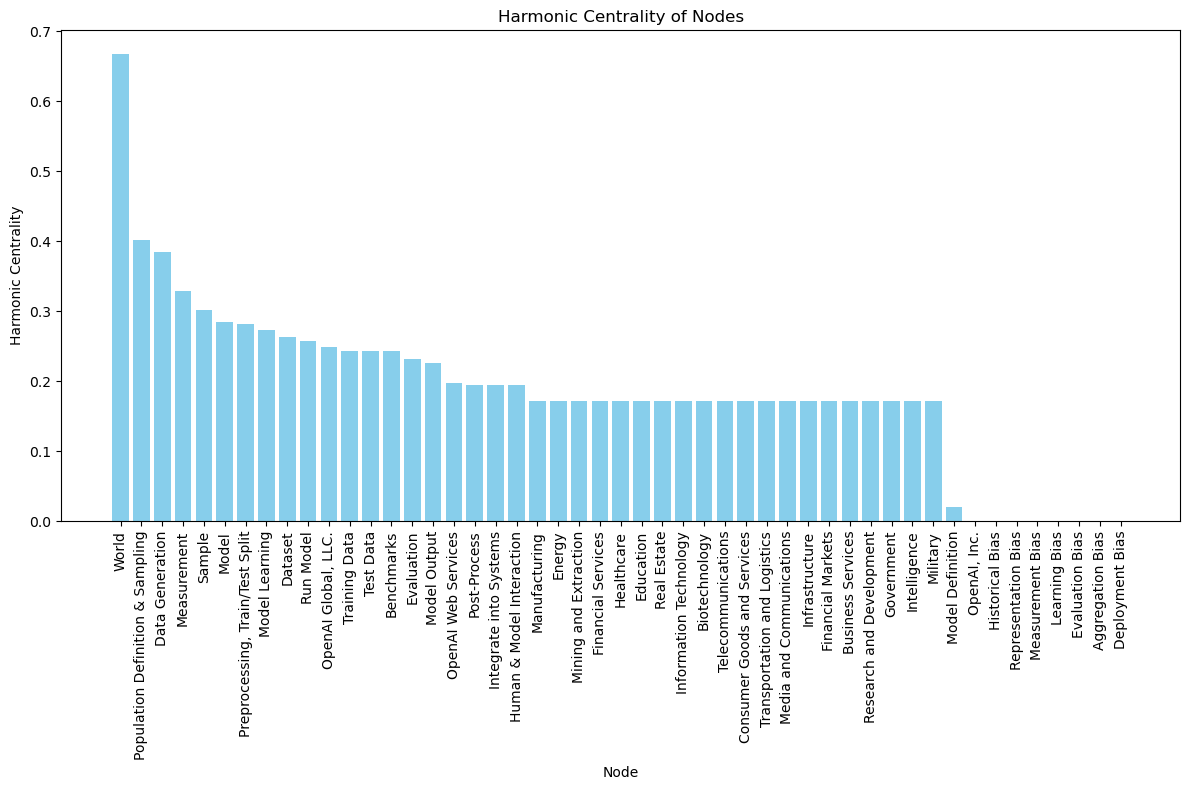

In [93]:
def my_neo4j_harmonic_centrality():
    """
    Compute the harmonic centrality for all nodes in the graph, print the results, and plot them.
    """
    driver = GraphDatabase.driver(uri="neo4j://54.156.52.158:7687", auth=("neo4j", "ucb_mids_w205"))
    session = driver.session(database="neo4j")
    
    # Drop the graph if it already exists
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    # Project the graph
    query = """
    CALL gds.graph.project(
        'ds_graph', 
        ['Company', 'ML_Workflow', 'PROCESS', 'BIAS'], 
        ['IS_PARENT_OF', 'FEEDS', 'BIASES']
    )
    """
    session.run(query)

    # Run the harmonic centrality algorithm
    query = """
    CALL gds.alpha.closeness.harmonic.stream('ds_graph')
    YIELD nodeId, centrality
    RETURN gds.util.asNode(nodeId).name AS node, centrality
    ORDER BY centrality DESC
    """

    result = session.run(query)
    data = []
    for r in result:
        data.append({"Node": r['node'], "Harmonic Centrality": r['centrality']})

    df = pd.DataFrame(data)

    print("\n--------------------------------")
    print("   Harmonic Centrality Results")
    print("--------------------------------")
    print(df)
    
    plt.figure(figsize=(12, 8))
    plt.bar(df['Node'], df['Harmonic Centrality'], color='skyblue')
    plt.xlabel('Node')
    plt.ylabel('Harmonic Centrality')
    plt.title('Harmonic Centrality of Nodes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

my_neo4j_harmonic_centrality()

The World is the most central node, with those nearest to the world being the population sampling and data generation processes. 

These results may suggest that lowering bias in ML, and in the World, could come from multiple actors, targeting different parts of the graph, with the same goals. 